# AtmoML Hyperparameter Tuning

In [1]:
import logging
import keras_tuner
import keras
import tensorflow as tf
import time
import pathlib
import os



from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)
# Create a MirroredStrategy to parallelize training on multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2025-10-22 22:15:56.373235: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 22:15:57.164295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 22:15:57.164385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 22:15:57.304773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 22:15:57.570581: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2025-10-22 22:16:05.002060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [2]:
with strategy.scope():
    tuner = keras_tuner.BayesianOptimization(
        AtmoModel.get_hypermodel(
            input_cnn_kernel_size=[1, 2, 5],
            lstm_kernel_size=[5],
            spatial_activation=["relu"],
            st_activation=["relu"],
            lstm_activation=["relu"],
            output_activation=["tanh"],
        ),
        objective="val_loss",
        max_trials=10,
        project_name=f"logs/htune_baseline_{timestamp}",
    )
    tuner.search_space_summary()


Search space summary
Default search space size: 6
input_cnn_kernel_size (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 5], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
spatial_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
st_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
lstm_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
output_activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}


In [3]:
log_dir = f"logs/htune_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 3 Complete [00h 05m 08s]
val_loss: 0.0017539041582494974

Best val_loss So Far: 0.0017539041582494974
Total elapsed time: 00h 11m 22s


{'input_cnn_kernel_size': 1,
 'lstm_kernel_size': 5,
 'spatial_activation': 'relu',
 'st_activation': 'relu',
 'lstm_activation': 'relu',
 'output_activation': 'tanh'}

In [4]:
with strategy.scope():
    # Re-create the model using the best hyperparameters
    final_params = AtmoModel.Params(**best_hp.values)
    model = AtmoModel(params=final_params)
    tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
    model.fit(train_ds, val_ds, epochs=200, callbacks=[tb_callback], validation_freq=1)
    model.save_model(log_dir + "/model")


Epoch 1/200
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2025-10-22 22:28:52.966641: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_15/atmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


      1/Unknown - 11s 11s/step - loss: 0.1328 - mean_absolute_error: 0.2908 - root_mean_squared_error: 0.3644 - mean_squared_logarithmic_error: 0.0873 - nrmse: 0.4008 - ssim_metric: 0.2007 - psnr_metric: 8.8466 - mse_RH2: 0.1818 - mse_T2: 0.2149 - mse_WSPD_WDIR10: 0.0015

2025-10-22 22:28:58.025101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14361363981545186257
2025-10-22 22:28:58.025145: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1366554237532751311
2025-10-22 22:28:58.025161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18183089717529839309
2025-10-22 22:28:58.025172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7940730422639470351
2025-10-22 22:28:58.025181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1319975301305670667
2025-10-22 22:28:58.025190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12641617179908906029
2025-10-22 22:28:58.025199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

1/1 [==============================] - 14s 14s/step - loss: 0.1328 - mean_absolute_error: 0.2908 - root_mean_squared_error: 0.3644 - mean_squared_logarithmic_error: 0.0873 - nrmse: 0.4008 - ssim_metric: 0.1003 - psnr_metric: 4.4233 - mse_RH2: 0.1818 - mse_T2: 0.2149 - mse_WSPD_WDIR10: 0.0015 - val_loss: 0.7111 - val_mean_absolute_error: 0.4879 - val_root_mean_squared_error: 0.8433 - val_mean_squared_logarithmic_error: 0.1765 - val_nrmse: 0.9275 - val_ssim_metric: 0.1221 - val_psnr_metric: 2.1564 - val_mse_RH2: 0.8061 - val_mse_T2: 0.5463 - val_mse_WSPD_WDIR10: 0.7810
Epoch 2/200


2025-10-22 22:29:00.962579: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18300269311623192630
2025-10-22 22:29:00.962634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13659015046386238103
2025-10-22 22:29:00.962646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17812280236190745439
2025-10-22 22:29:00.962654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11502964968170458159
2025-10-22 22:29:00.962661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12869935128099933949
2025-10-22 22:29:00.962668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13434831956755239677
2025-10-22 22:29:00.962675: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous re

1/1 [==============================] - 3s 3s/step - loss: 0.6550 - mean_absolute_error: 0.4673 - root_mean_squared_error: 0.8093 - mean_squared_logarithmic_error: 0.1661 - nrmse: 0.8902 - ssim_metric: 0.2098 - psnr_metric: 4.4813 - mse_RH2: 0.7949 - mse_T2: 0.4255 - mse_WSPD_WDIR10: 0.7448 - val_loss: 0.3548 - val_mean_absolute_error: 0.3496 - val_root_mean_squared_error: 0.5956 - val_mean_squared_logarithmic_error: 0.1158 - val_nrmse: 0.6551 - val_ssim_metric: 0.2155 - val_psnr_metric: 7.0439 - val_mse_RH2: 0.1444 - val_mse_T2: 0.5607 - val_mse_WSPD_WDIR10: 0.3592
Epoch 3/200
1/1 [==============================] - 3s 3s/step - loss: 0.3776 - mean_absolute_error: 0.3657 - root_mean_squared_error: 0.6145 - mean_squared_logarithmic_error: 0.1223 - nrmse: 0.6759 - ssim_metric: 0.1644 - psnr_metric: 6.0766 - mse_RH2: 0.2407 - mse_T2: 0.5402 - mse_WSPD_WDIR10: 0.3519 - val_loss: 0.1154 - val_mean_absolute_error: 0.2489 - val_root_mean_squared_error: 0.3396 - val_mean_squared_logarithmic_err

INFO:tensorflow:Assets written to: logs/htune_20251022-221604/model/assets


/home/vupparal/climateiq-cnn-1/usl_models/usl_models/atmo_ml/visualizer.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, T, figsize=(2 * (T + 0.2), 2), sharey=True)


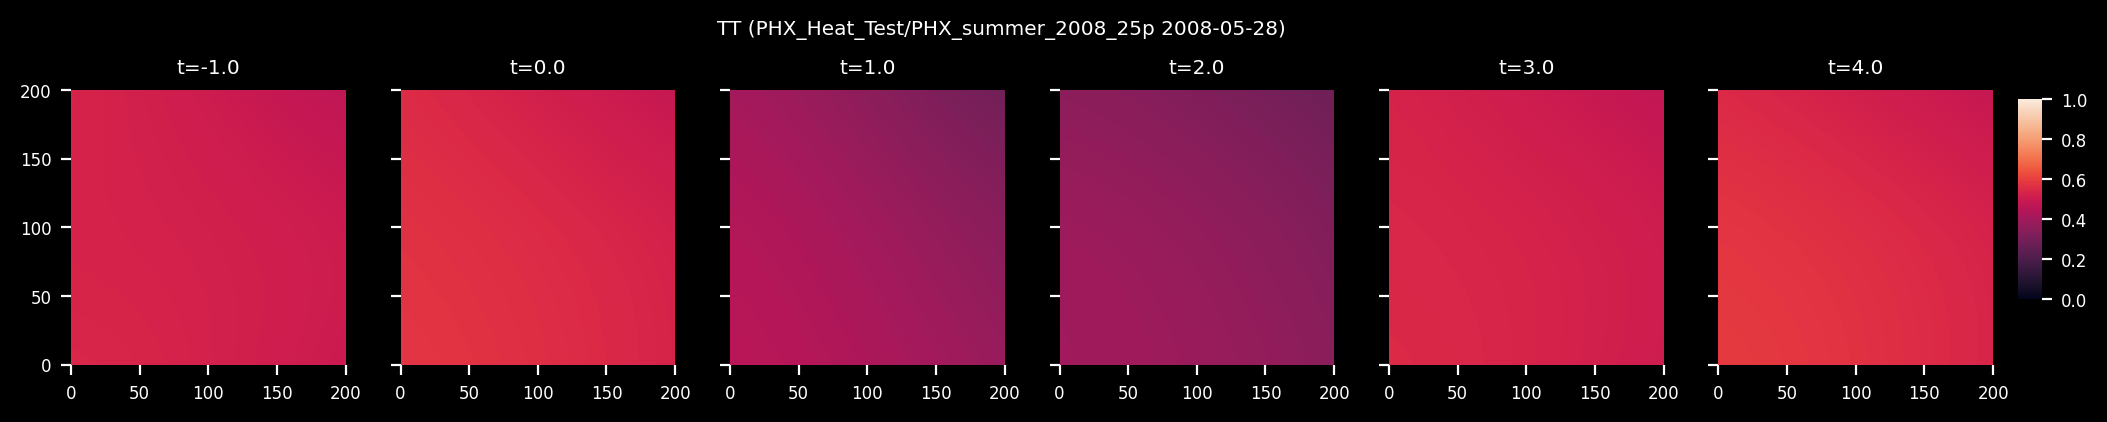

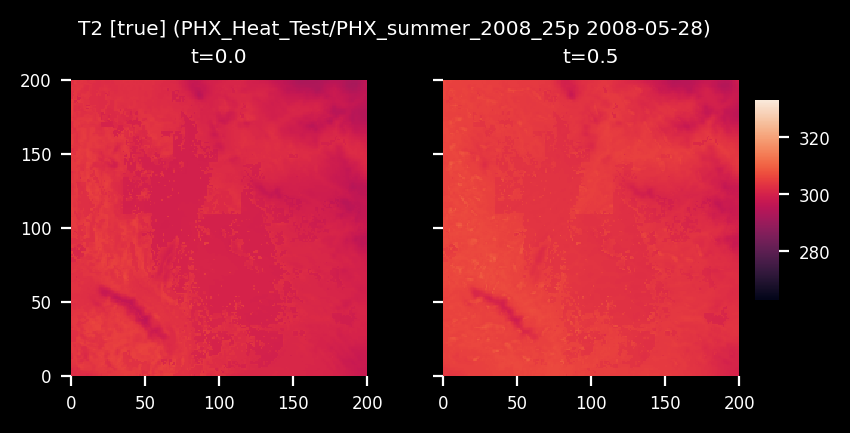

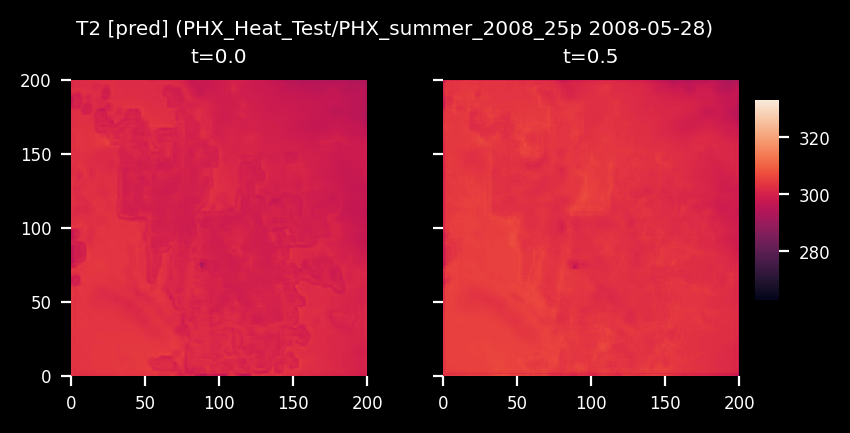

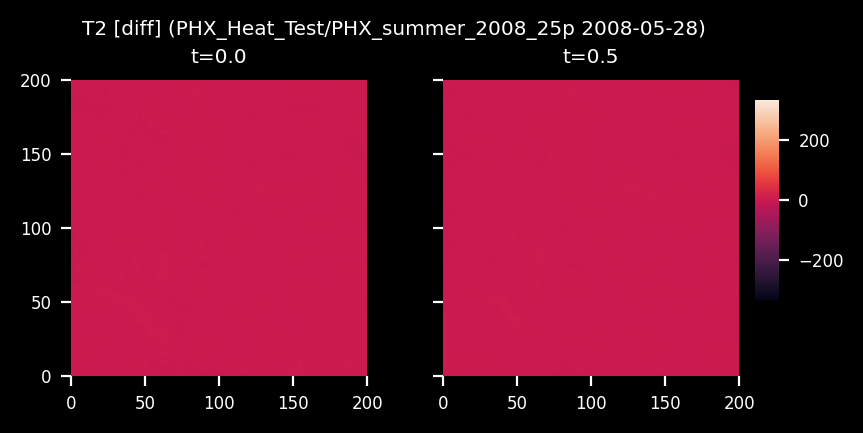

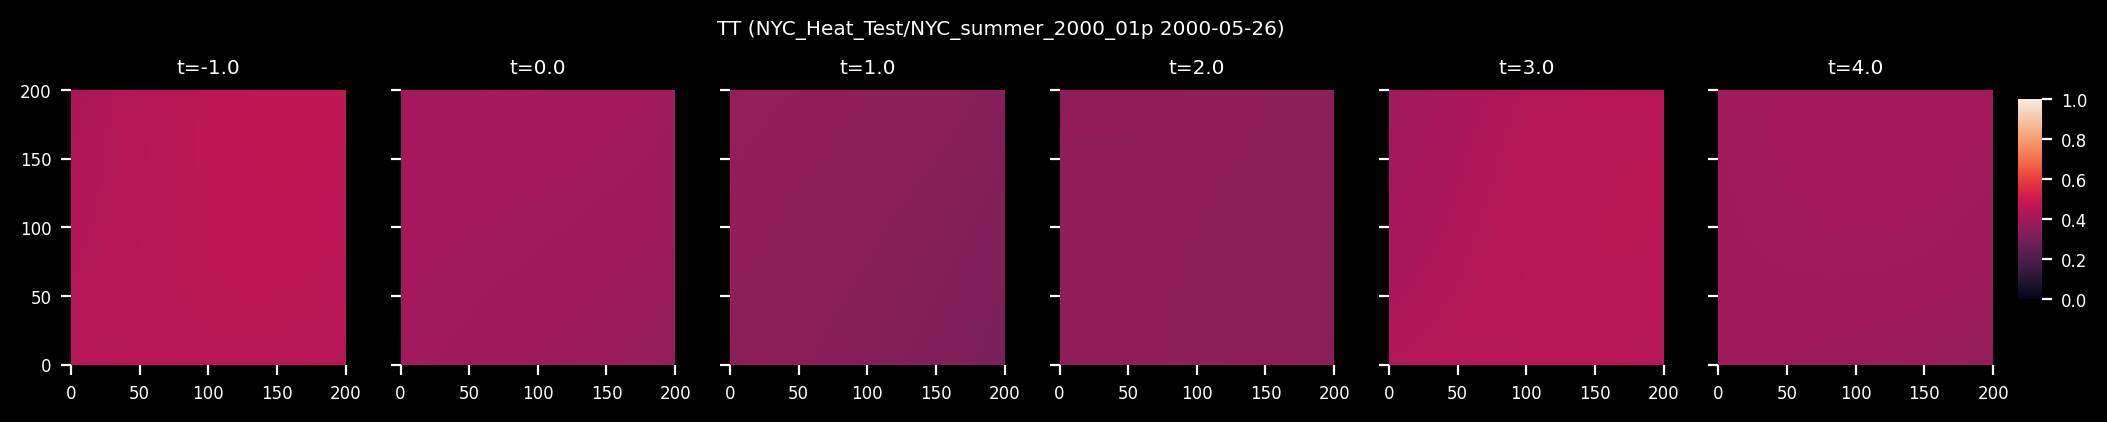

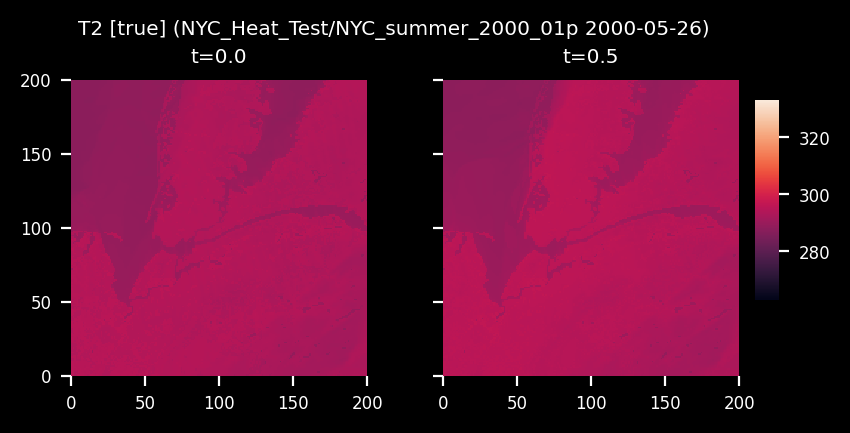

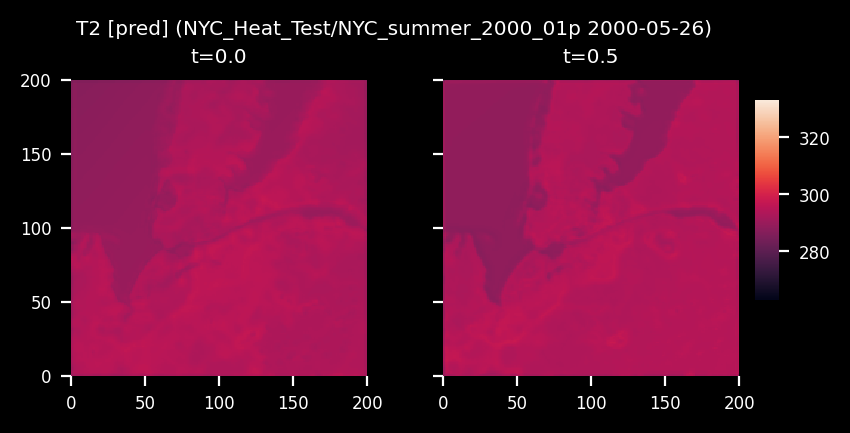

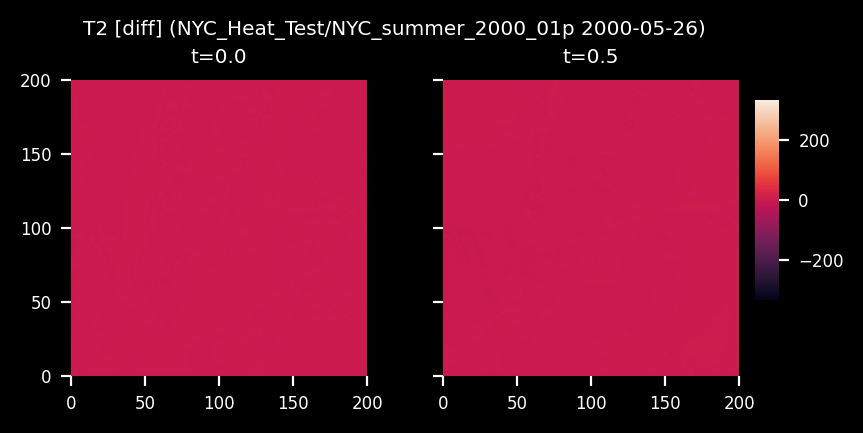

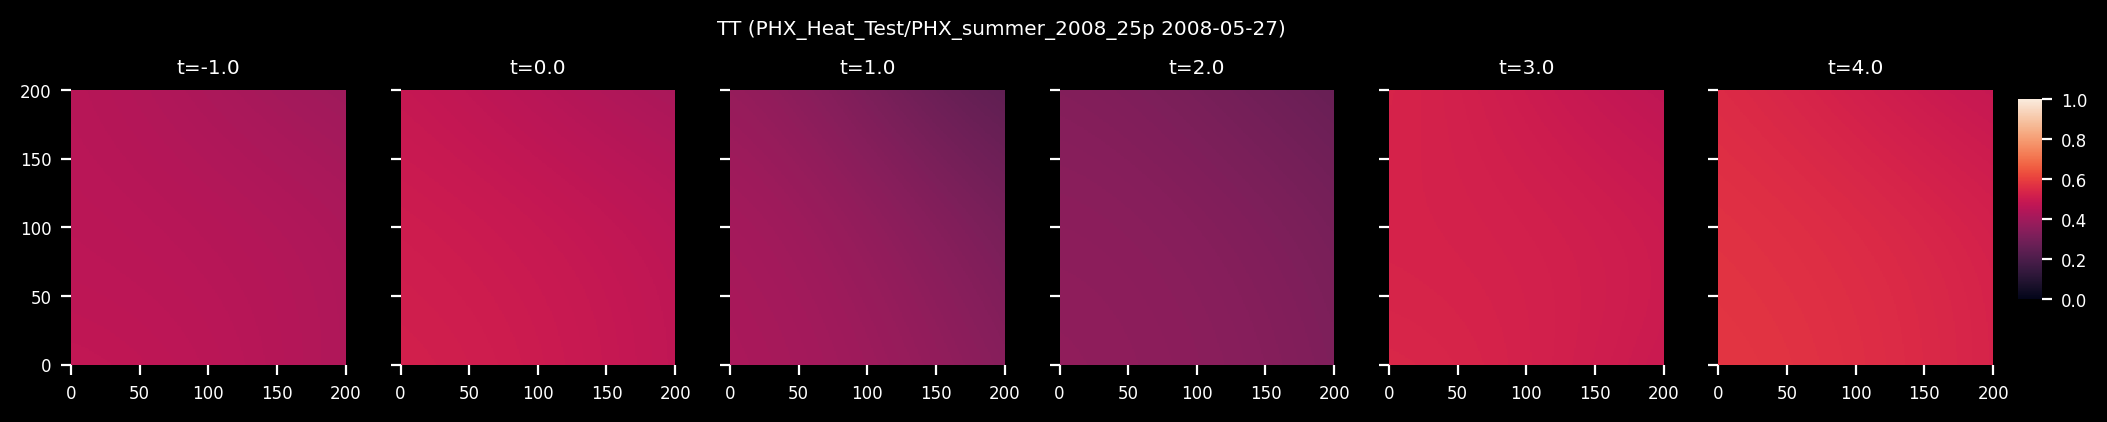

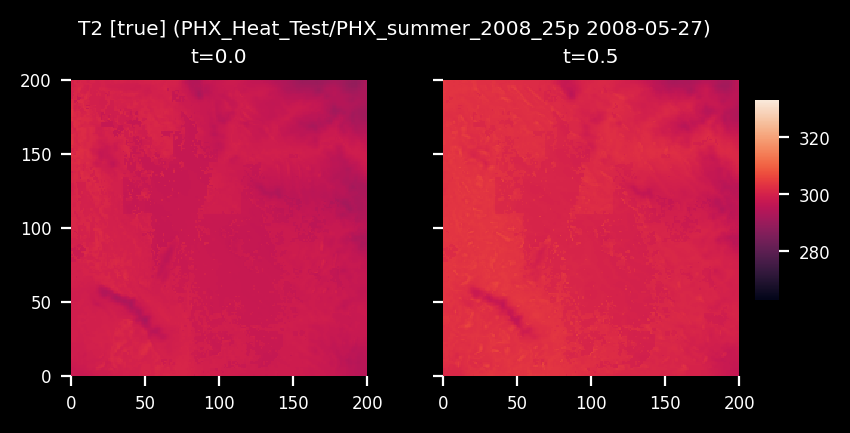

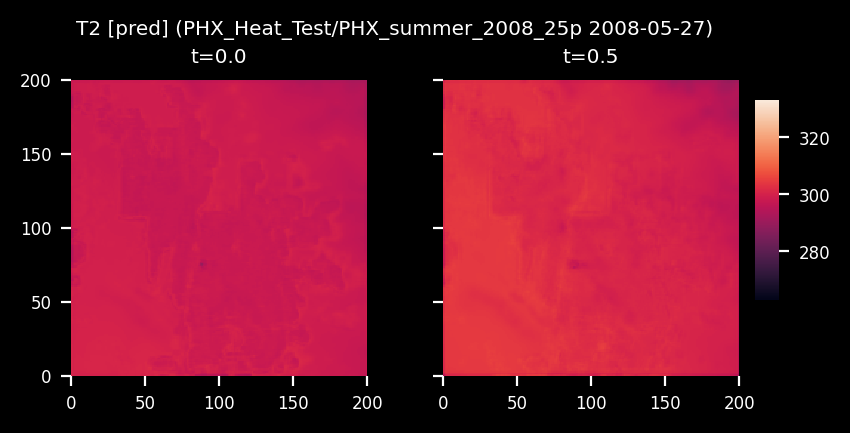

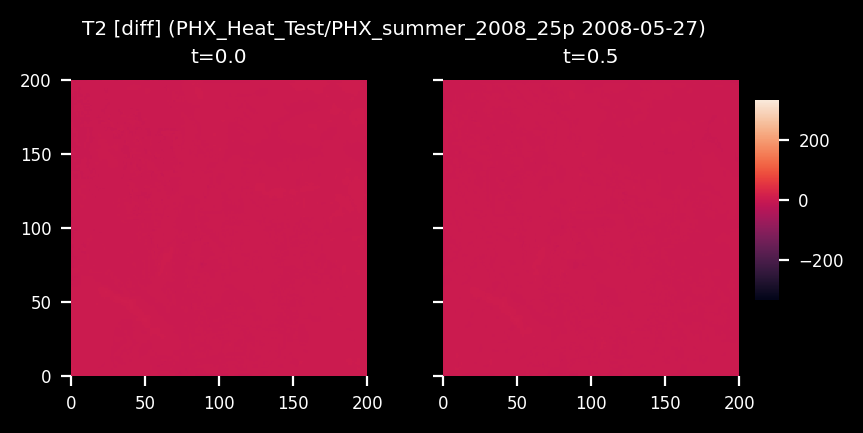

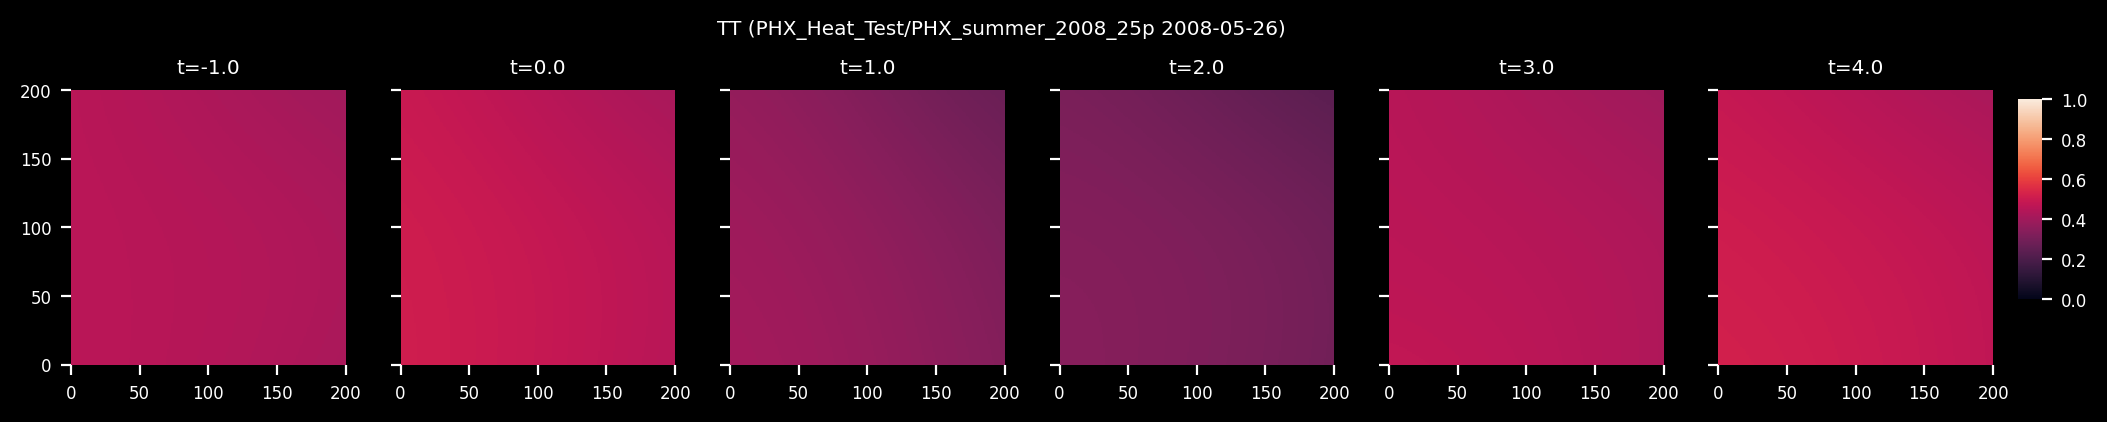

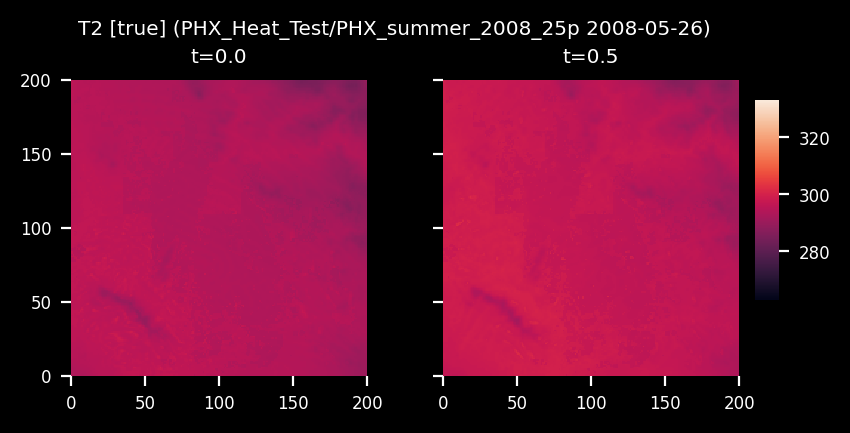

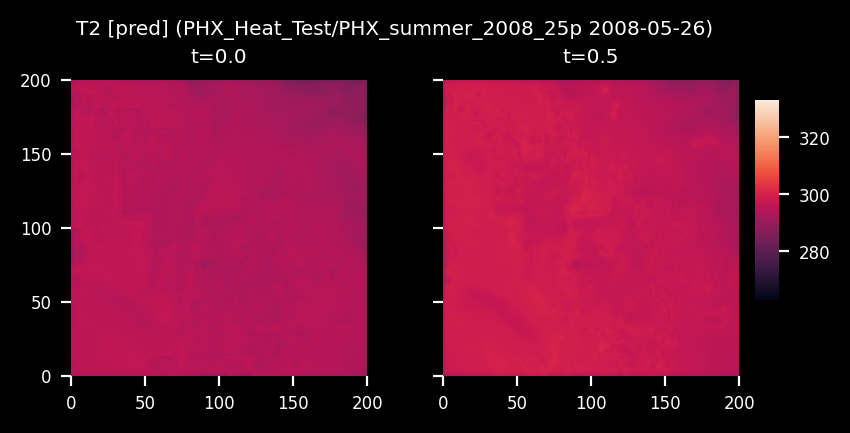

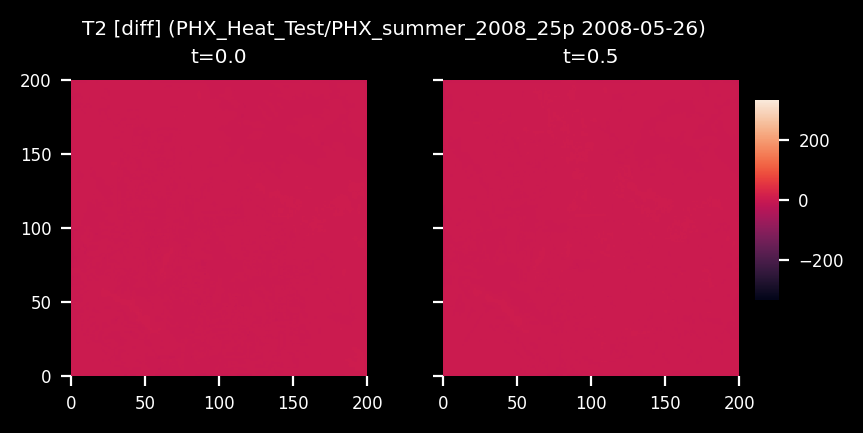

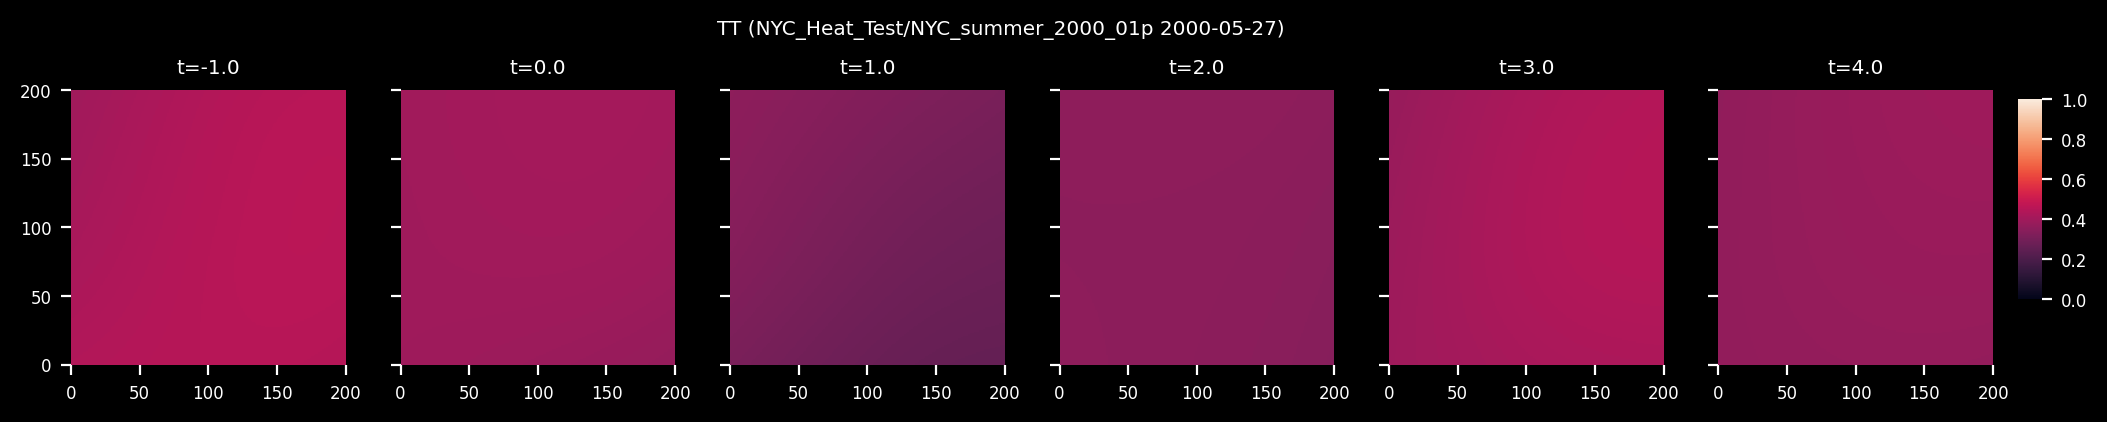

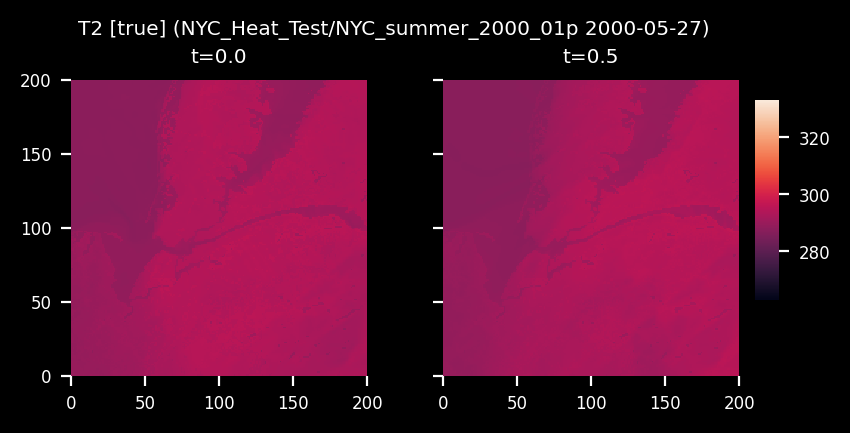

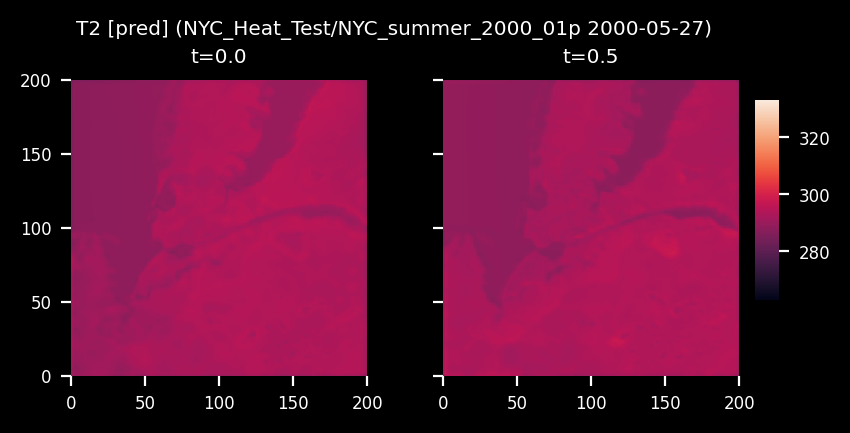

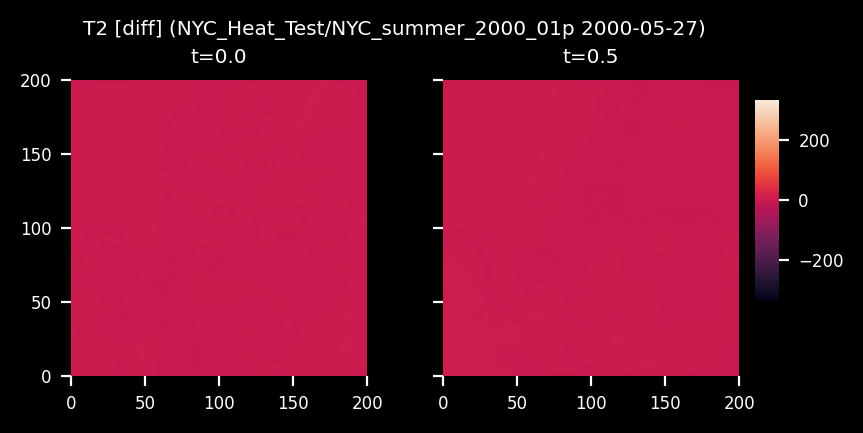

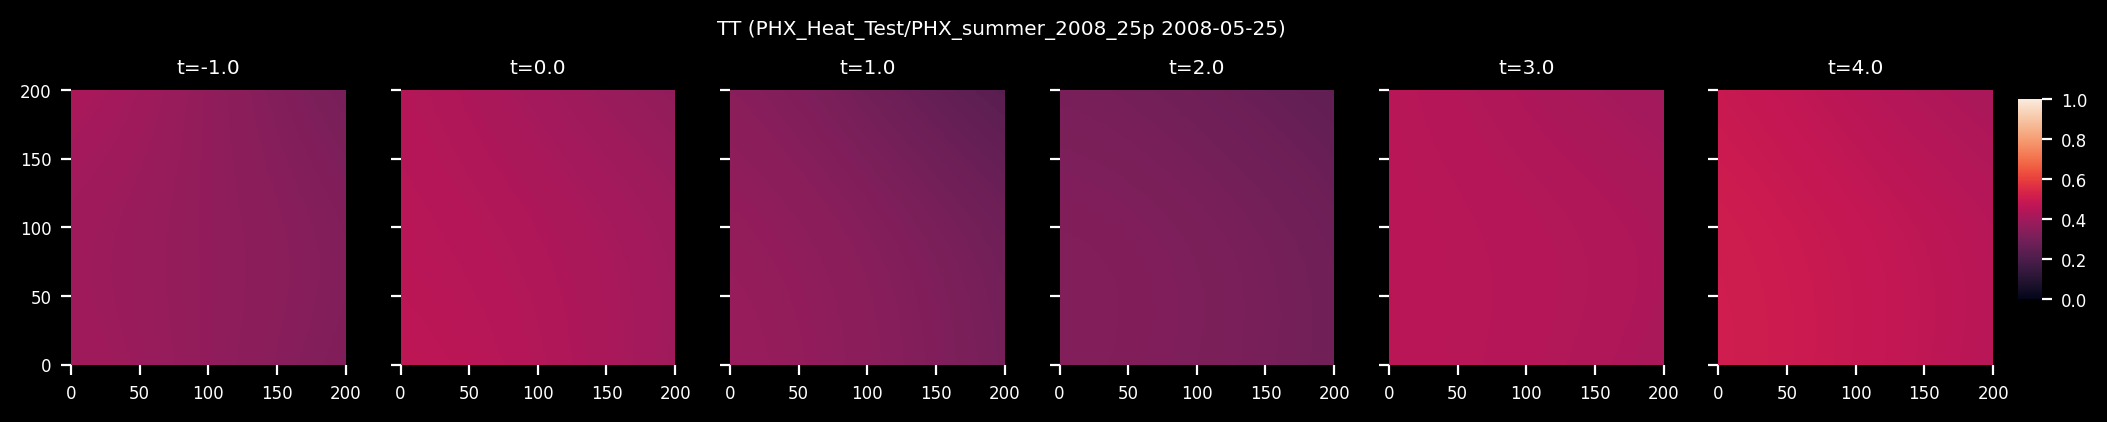

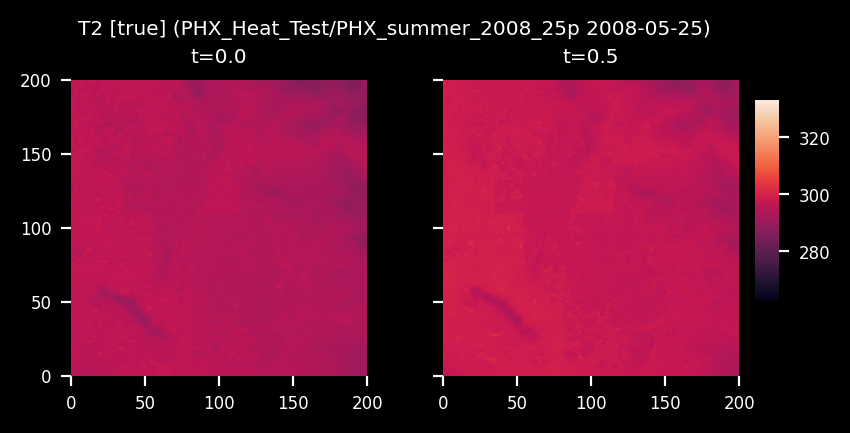

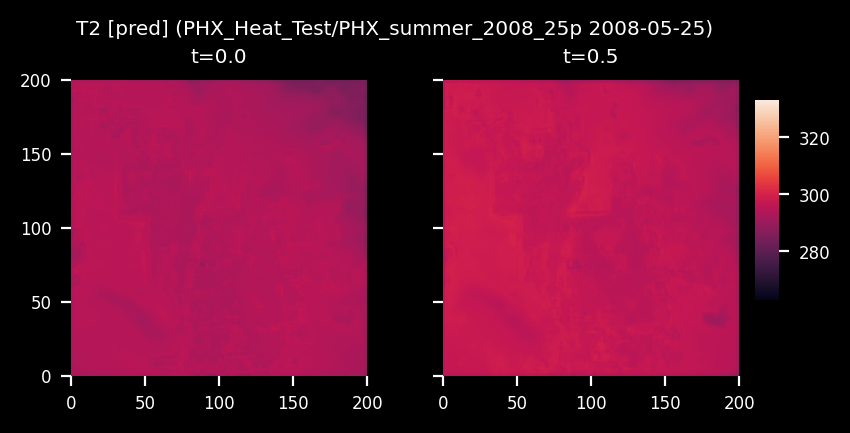

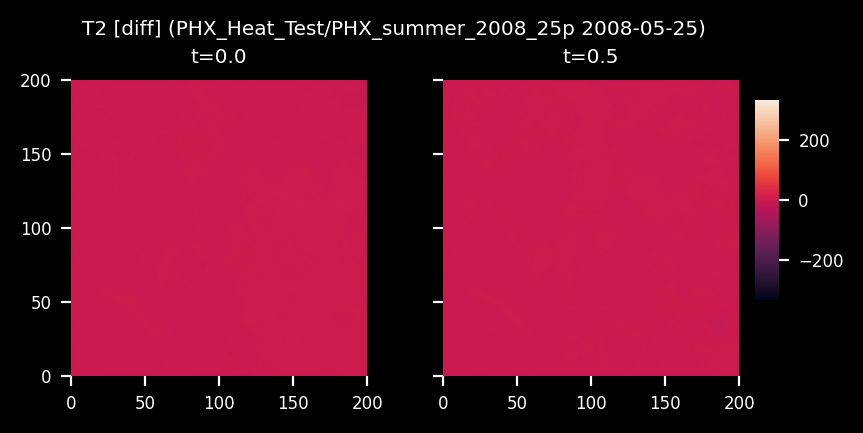

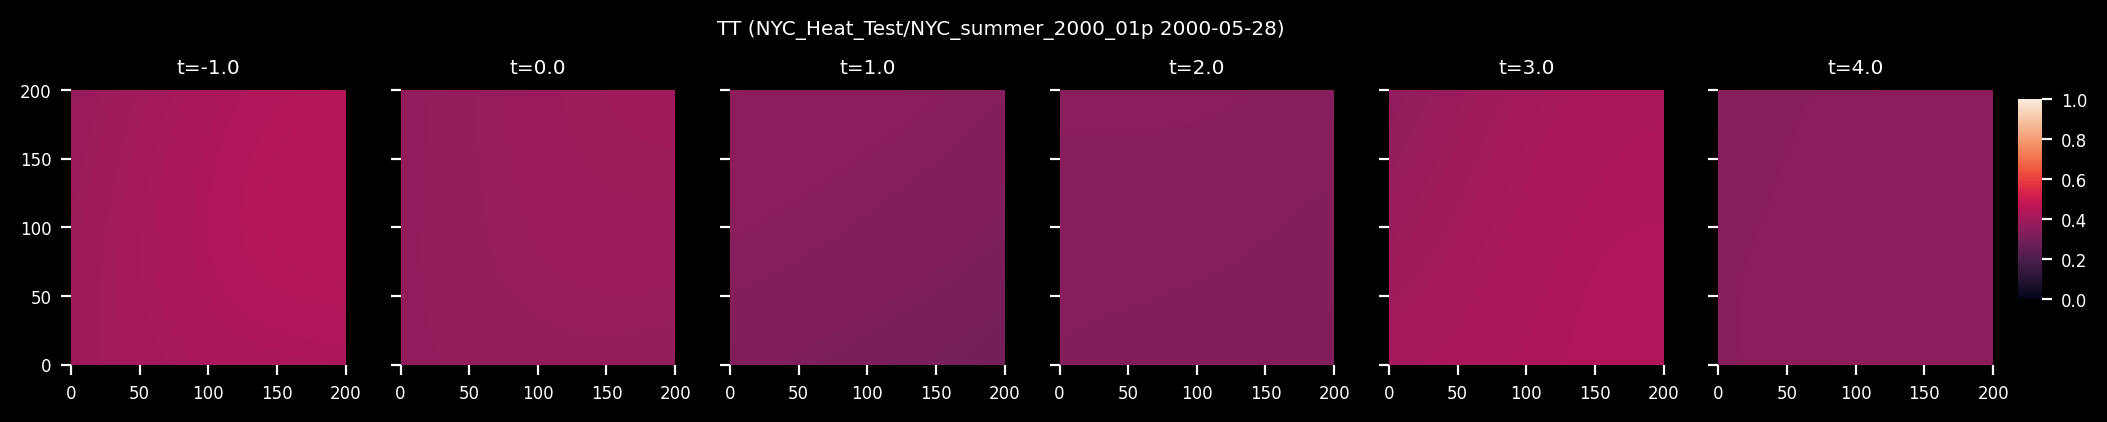

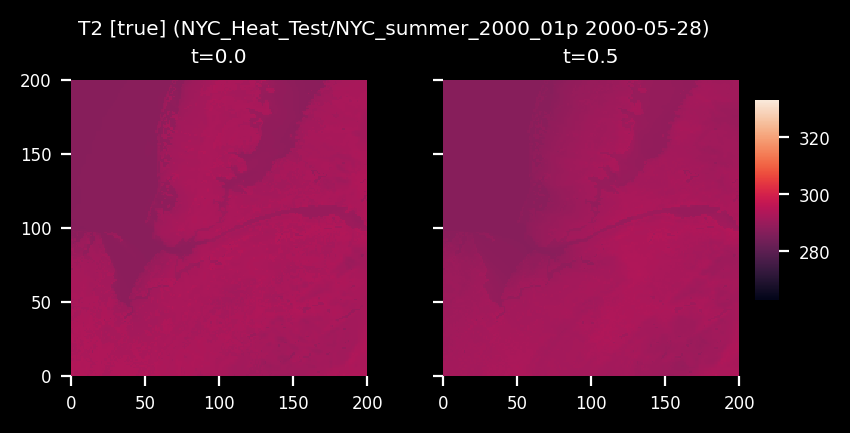

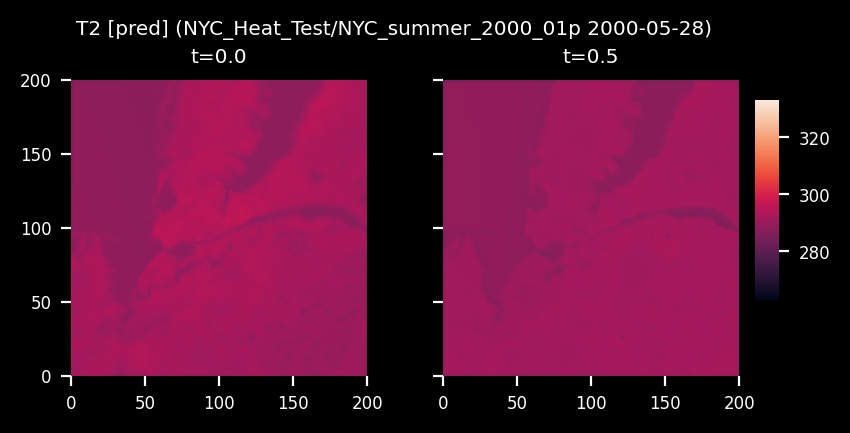

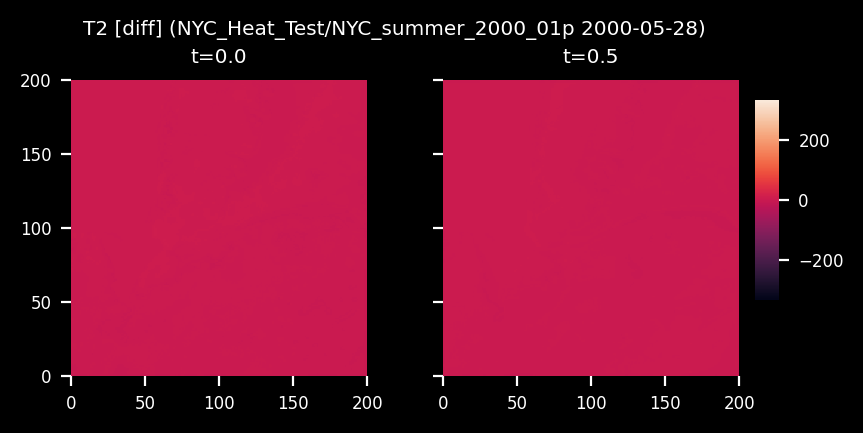

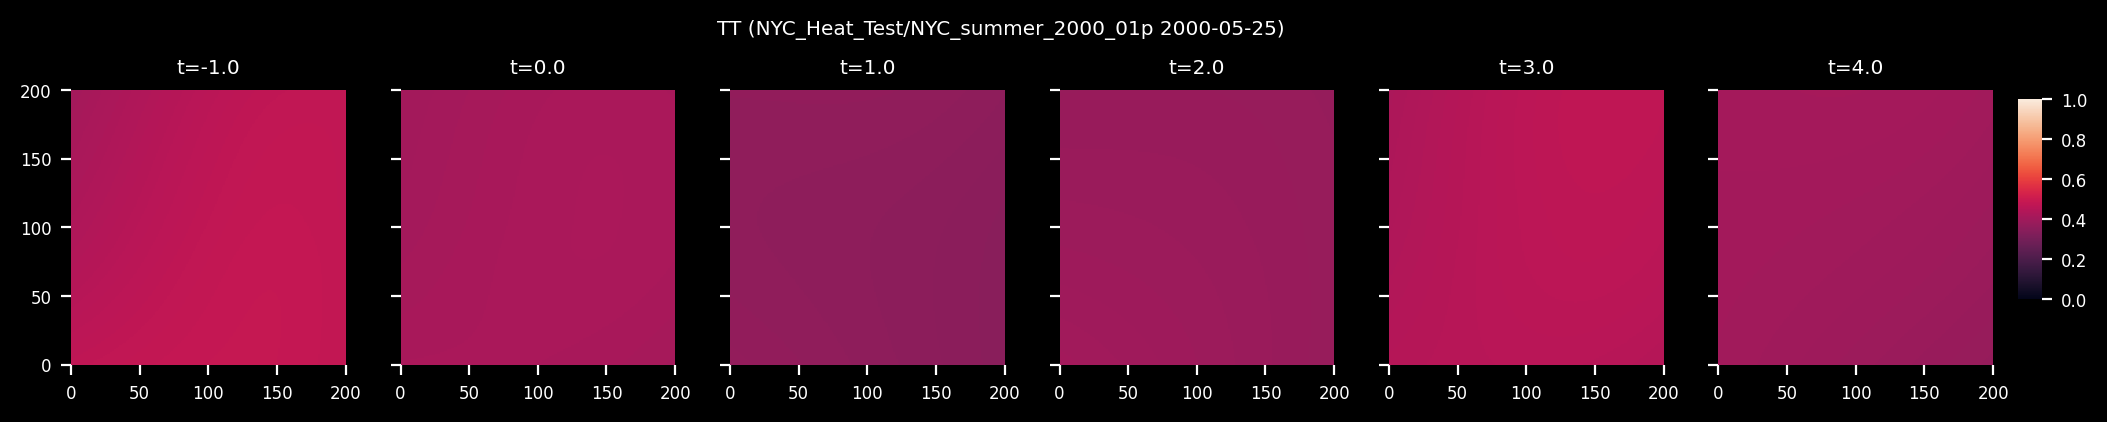

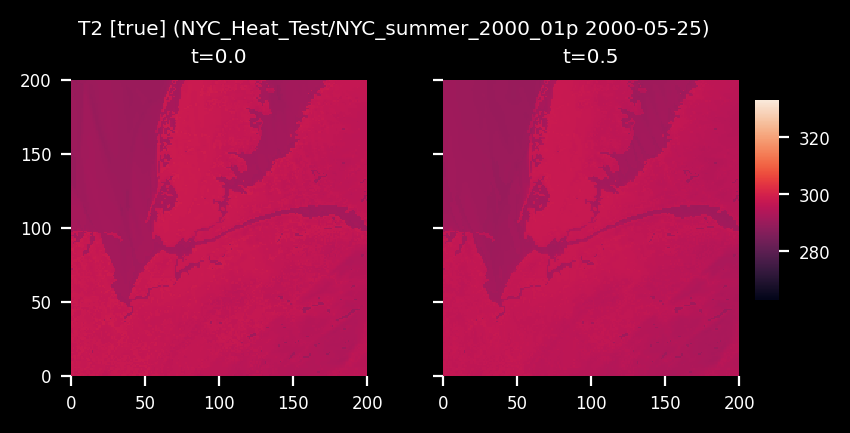

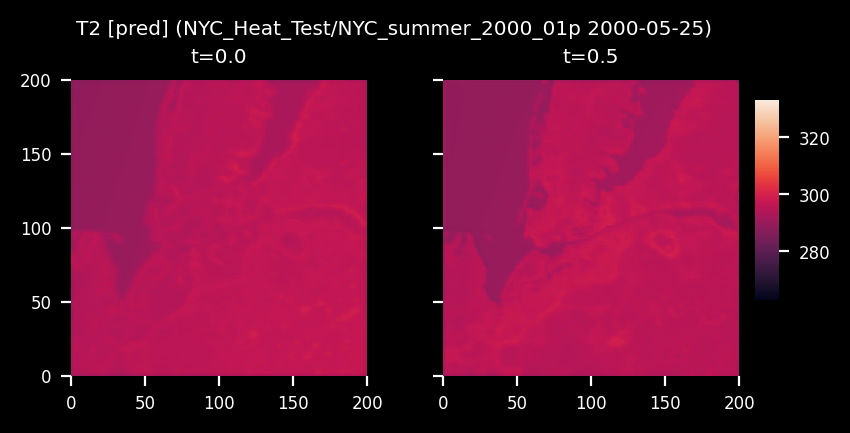

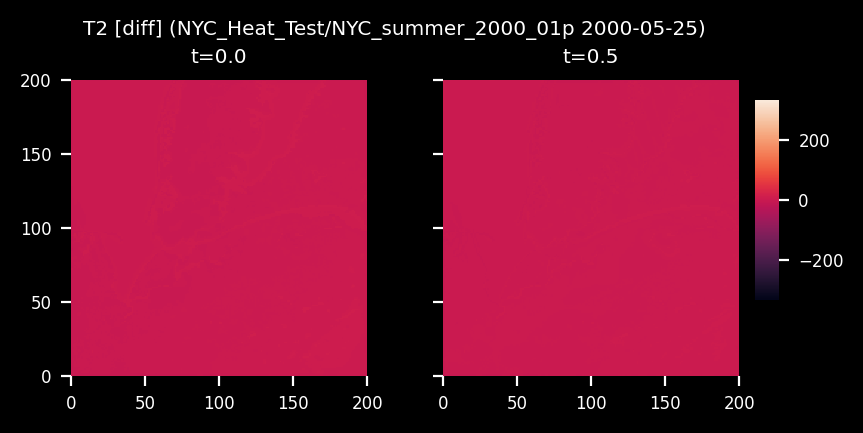

In [5]:
# Plot results
model = AtmoModel.from_checkpoint(log_dir + "/model")
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    ds_config,
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.TT,
    sto_var=vars.SpatiotemporalOutput.T2,
    max_examples=None,
    dynamic_colorscale=False,  # Set to True to compute from data
    unscale= True    # Revert normalization to show true values
):
    fig.show()